In [1]:
# This is required to run multiple processes on Unity for some reason.
from multiprocessing import set_start_method
try:
    set_start_method('spawn')
except: #Throws if already set
    pass

# Disable CUDA graphs
import os
os.environ['XLA_FLAGS'] = '--xla_gpu_enable_command_buffer='


In [2]:
%matplotlib widget
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jax
from pathlib import Path
from importlib import reload

src = str(Path('../src').resolve())
if src not in sys.path:
    sys.path.append(src)
from train import load_last_state
from data import TAPDataset, TAPDataLoader
from evaluate import predict, get_all_metrics

In [143]:
# run_dir = Path("../runs/transformer_layer_tune/2layer_2head_20240606_142302")
run_dir = Path("../runs/hybrid_ensemble_flux/2head_2layer_064_20240606_235758")
cfg, model, _, _ = load_last_state(run_dir)
cfg['quiet'] = False

# dataset = TAPDataset(cfg)

Loading model state from ../runs/hybrid_ensemble_flux/2head_2layer_064_20240606_235758/epoch090


In [151]:
cfg['data_subset'] = 'test'
cfg['num_workers'] = 2
cfg['basin_subset'] = None
dataloader = TAPDataLoader(cfg, dataset)

results, metrics = predict(model, dataloader, seed=0, denormalize=True, return_dt=True)


Dataloader using 2 parallel CPU worker(s).
Batch sharding set to 1 cpu(s)


  0%|          | 0/313 [00:16<?, ?it/s]

nBias: 0.1391
rRMSE: 289.5375
KGE: 0.6391
NSE: 0.2686
lNSE: 0.7657
Agreement: 0.7129


/work/pi_kandread_umass_edu/tss-ml/src/evaluate.py:119: RuntimeWarning: invalid value encountered in log
  log_y = np.log(y)


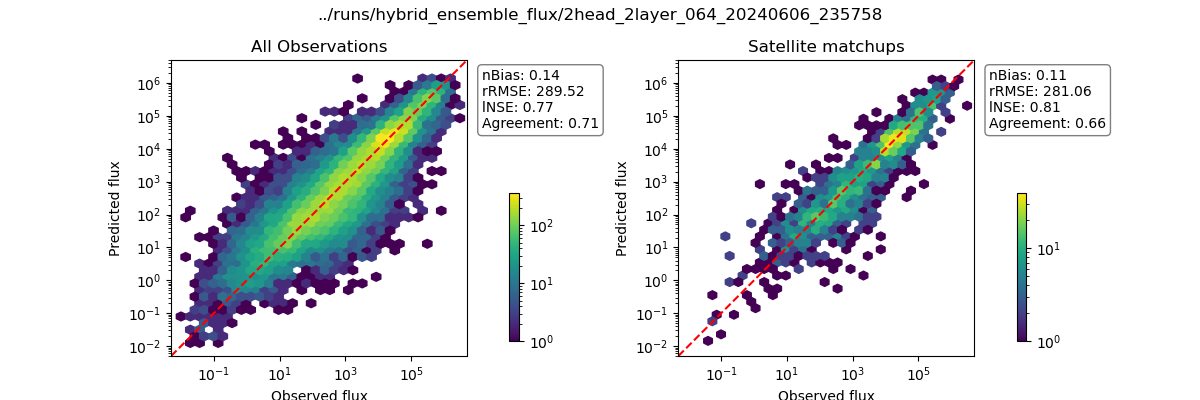

In [152]:
plt.close('all')

import evaluate
reload(evaluate)
from evaluate import get_all_metrics

def scatter_1to1(ax, x, y, target):
    positive_mask = (x > 0) & (y > 0)
    x = x[positive_mask]
    y = y[positive_mask]

    hb = ax.hexbin(x, y, gridsize=(30,20), bins='log', xscale='log', yscale='log')
    cb = plt.colorbar(hb, shrink=0.5, aspect=15, anchor=(0,0.1))
    
    # Adding a 1:1 line over the min and max of x and y
    min_val = 5E-3
    max_val = 5E6
    ax.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    metrics = get_all_metrics(x,y)
    textstr = '\n'.join([f"{key}: {metrics[key]:0.2f}" for key in ['nBias', 'rRMSE', 'lNSE', 'Agreement']])
    props = dict(boxstyle='round', facecolor='white', alpha=0.5)
    ax.text(1.05, 0.97, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)

    # Setting axes to be square and equal range
    ax.axis('square')
    ax.set_xlim(min_val, max_val)
    ax.set_ylim(min_val, max_val)
    ax.set_xlabel(f'Observed {target}')
    ax.set_ylabel(f'Predicted {target}')
    
    
fig, axes = plt.subplots(1,2, figsize=(12, 4))

x = results['obs']
y = results['pred']
scatter_1to1(axes[0], x, y, cfg['features']['target'])
axes[0].set_title('All Observations')

mask = results['dt'] == 0
x = x[mask]
y = y[mask]
scatter_1to1(axes[1], x, y, cfg['features']['target'])
axes[1].set_title('Satellite matchups')

fig.subplots_adjust(top=0.85)
fig.suptitle(str(run_dir))


plt.show()
fig.savefig(run_dir / "density_scatter.png",  dpi=300)

/home/tlanghorst_umass_edu/.conda/envs/tss-ml/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


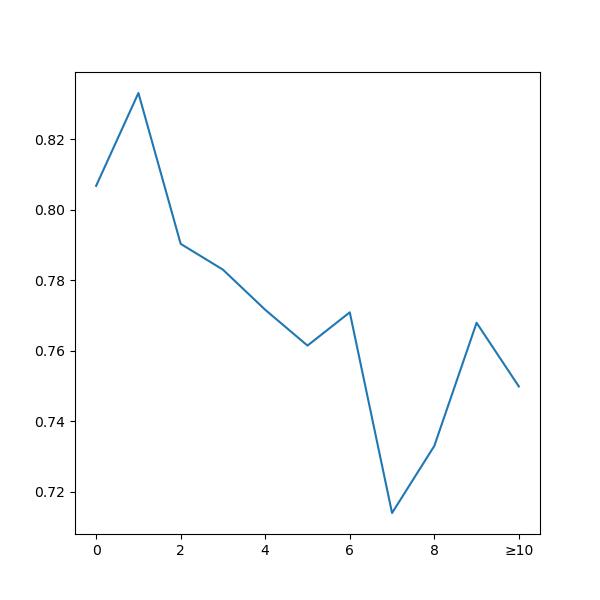

In [153]:
plt.close('all')

fig, ax = plt.subplots(figsize=(6,6))

x = results['obs']
y = results['pred']
z = []

dt_max = 10
for dt in range(dt_max+1):
    if dt < dt_max:
        mask = np.abs(results['dt']) == dt
    else:
        mask = np.abs(results['dt']) >= dt
    metrics = get_all_metrics(x[mask], y[mask])
    z.append(metrics['lNSE'])

ax.plot(z)

xticks = range(0,dt_max+1,2)
xtick_labels = ax.get_xticklabels()
new_labels = ["≥" + str(int(tick)) if tick == dt_max else str(int(tick)) for tick in xticks]
ax.set_xticks(xticks)
ax.set_xticklabels(new_labels)

plt.show()

In [154]:
import evaluate
reload(evaluate)
from evaluate import predict, get_all_metrics

basin = np.random.choice(dataset.basins).tolist()
# basin = 'USGS-09367540'
# basin = 'USGS-06109500' #no flux but nice seasonality
basin = 'USGS-08332010' #Nice flux temporal distribution and seasonality

cfg['data_subset'] = 'predict'
cfg['basin_subset'] =  basin
cfg['num_workers'] = 0 # Faster for small runs
dataloader = TAPDataLoader(cfg, dataset)

results, metrics = predict(model, dataloader, seed=0, denormalize=True, return_dt=True)
results['pred'] = results['pred'] * (results['pred']>0) #Clip predictions to 0

results = results.reset_index()
results = results.sort_values(by='date')
results = results.drop(columns=['basin'])
results.set_index('date', inplace=True)

Dataloader using 0 parallel CPU worker(s).
Batch sharding set to 1 cpu(s)


  0%|          | 0/51 [00:00<?, ?it/s]

nBias: 0.3388
rRMSE: 257.1209
KGE: 0.0909
NSE: -2.4629
lNSE: 0.5202
Agreement: 0.2368


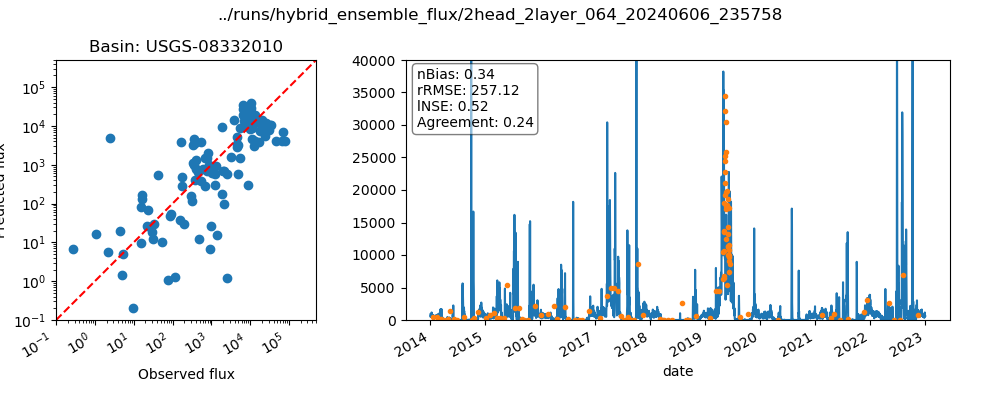

In [157]:
import matplotlib.gridspec as gridspec
# Plot the true values and predictions
plt.close('all')


# Create a figure
fig = plt.figure(figsize=(10, 4))

# Create a GridSpec with 1 row and 3 columns
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 0.2, 2])
axes = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 2])]

pred = results['pred']
obs = results['obs']



min_val = 1E-1
max_val = 5E5
axes[0].scatter(obs, pred)
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--')

# Setting axes to be square and equal range
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].axis('square')
axes[0].set_xlim(min_val, max_val)
axes[0].set_ylim(min_val, max_val)
axes[0].set_xlabel(f"Observed {cfg['features']['target']}")
axes[0].set_ylabel(f"Predicted {cfg['features']['target']}")

axes[0].set_title(f"Basin: {basin}")


pred.plot(ax=axes[1])
obs.plot(ax=axes[1], linestyle='None',marker='.')
axes[1].set_ylim([0,40000])

textstr = '\n'.join([f"{key}: {metrics[key]:0.2f}" for key in ['nBias', 'rRMSE', 'lNSE', 'Agreement']])
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
axes[1].text(0.02, 0.97, textstr, transform=axes[1].transAxes, fontsize=10,
        va='top', ha='left', bbox=props)


fig.subplots_adjust(top=0.85, left=0.05, right=0.95, wspace=0.05, hspace=0.4)
fig.suptitle(str(run_dir))
fig.autofmt_xdate()

plt.show()

fig.savefig(run_dir / f"{basin}_timeseries.png",  dpi=300)